# Smart Device Human Activity Recognition (HAR) Model (Using Feature Engineering?)

[Eugene Zen](mailto:ezen@ucsd.edu), [Shane Luna](mailto:shluna@ucsd.edu)

## I. Summary
This notebook presents the development of a Human Activity Recognition (HAR) model that utilizes sensors from both smartphones and smartwatches. The data was originally collected and analyzed by the members of the WISDM (Wireless Sensor Data Mining) Lab in the Department of Computer and Information Science of Fordham University. More information on the original experiment can be found in the publication from 2019 [here](https://ieeexplore.ieee.org/document/8835065). The data was made publicly available on the UCI Machine Learning Repository as the "WISDM Smartphone and Smartwach Activity and Biometrics Dataset" and can be found [here](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+).

## II. Development

### A. Dependencies

In [58]:
%matplotlib inline

from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import string
import os

In [2]:
# Start local dask client
client = Client(n_workers=4)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:38631 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.82 GiB


### B. Load Data

In [4]:
def read_file(filepath):
    df = dd.read_csv(filepath, sep = ',', header = None)
    df.columns = ['subject_id', 'activity_code', 'timestamp', 'x', 'y', 'z']
    df['timestamp_dt'] = dd.to_datetime(df['timestamp'], origin='unix') # phone in microseconds / watch in milliseconds -- letting infer
    df['z'] = df['z'].str.replace(";","").astype('float64') # remove ; and ensure float (having issues with lineterminator)
    return df

In [94]:
# Phone Data
phone_accel_df = read_file('wisdm-dataset/raw/phone/accel/*.txt')
phone_gyro_df = read_file('wisdm-dataset/raw/phone/gyro/*.txt')

# Watch Data
watch_accel_df = read_file('wisdm-dataset/raw/watch/accel/*.txt')
watch_gyro_df = read_file('wisdm-dataset/raw/watch/gyro/*.txt')

Referring to the dataset description provided from the WISDM Lab, one would expect to see the following row counts:

- raw/phone/accel: 4,804,403
- raw/phone/gyro: 3,608,635
- raw/watch/accel: 3,777,046
- raw/watch/gyro: 3,440,342

In [6]:
print(f'Phone Accel:\t{len(phone_accel_df)}')
print(f'Phone Gyro:\t{len(phone_gyro_df)}')
print(f'Watch Accel:\t{len(watch_accel_df)}')
print(f'Watch Gyro:\t{len(watch_gyro_df)}')

Phone Accel:	4804403
Phone Gyro:	3608635
Watch Accel:	3777046
Watch Gyro:	3440342


All of the above dataframes are stuctured similarly. A sample output of the column datatypes has been provided below for reference. An additional column, timestamp_dt, was added to the original data by converting the timestamp attribute to a datetime object type. The original timestamp column has been preserved if needed for future enhancements.

In [7]:
print(phone_accel_df.dtypes)

subject_id                int64
activity_code            object
timestamp                 int64
x                       float64
y                       float64
z                       float64
timestamp_dt     datetime64[ns]
dtype: object


### C. Exploratory Data Analysis (EDA)

First, a check is done for any null values in the data. As expected, none were found.

In [8]:
# Check for nulls

print('--Phone Accel--')
print(phone_accel_df.isna().sum().compute())

print('--Phone Gyro--')
print(phone_gyro_df.isna().sum().compute())

print('--Watch Accel--')
print(watch_accel_df.isna().sum().compute())

print('--Watch Gyro--')
print(watch_gyro_df.isna().sum().compute())

--Phone Accel--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Phone Gyro--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Watch Accel--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Watch Gyro--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64


Second, a check was done for any missing sensor datasets.

i.e. Did all subjects actually do all activites and are readings available for each activity on each sensor?

In [9]:
# Which sensors have missing activities
subjects = phone_accel_df['subject_id'].unique().compute()
activities = phone_accel_df['activity_code'].unique().compute()

subject_activities_df = pd.DataFrame(subjects).merge(pd.DataFrame(activities), how='cross')

phone_accel_interval_counts = phone_accel_df.groupby(['subject_id', 'activity_code']).size().rename('phone_accel').reset_index().compute()
subject_activities_df = subject_activities_df.merge(phone_accel_interval_counts, on=['subject_id', 'activity_code'], how='left')

phone_gyro_interval_counts = phone_gyro_df.groupby(['subject_id', 'activity_code']).size().rename('phone_gyro').reset_index().compute()
subject_activities_df = subject_activities_df.merge(phone_gyro_interval_counts, on=['subject_id', 'activity_code'], how='left')

watch_accel_interval_counts = watch_accel_df.groupby(['subject_id', 'activity_code']).size().rename('watch_accel').reset_index().compute()
subject_activities_df = subject_activities_df.merge(watch_accel_interval_counts, on=['subject_id', 'activity_code'], how='left')

watch_gyro_interval_counts = watch_gyro_df.groupby(['subject_id', 'activity_code']).size().rename('watch_gyro').reset_index().compute()
subject_activities_df = subject_activities_df.merge(watch_gyro_interval_counts, on=['subject_id', 'activity_code'], how='left')

subject_activities_df = subject_activities_df.set_index(['subject_id'])

subject_activities_df.isna().sum()

activity_code     0
phone_accel       8
phone_gyro       10
watch_accel       6
watch_gyro       11
dtype: int64

Below are the details for which subject activities are missing sensor data. One might also notice that read frequencies are higher for certain sensor data. @20Hz, 3 minutes of activity data should be 3600 readings per activity. For some activities below, it lists > 8000 readings for certain sensors. This is an anomaly called out in the original research publication. It was stated that "due to the nature of the Android OS, the sampling rate is only taken as a suggestion, so actual sampling rates sometimes differed." 

In [10]:
subject_activities_df[subject_activities_df.isna().any(axis=1)]

,activity_code,phone_accel,phone_gyro,watch_accel,watch_gyro
subject_id,,,,,
1607,J,NaN,NaN,3603.0,3602.0
1609,B,NaN,NaN,3605.0,3603.0
1616,B,NaN,NaN,NaN,NaN
1616,F,NaN,NaN,3605.0,3603.0
1618,O,NaN,NaN,NaN,NaN
1637,C,3600.0,3598.0,8931.0,NaN
1637,J,3600.0,3598.0,NaN,NaN
1638,H,3615.0,3613.0,8931.0,NaN
1638,O,3601.0,3599.0,8936.0,NaN


To confirm the sampling rate discrepancy listed above, a test is performed. The main cause of high reads could be due to one of two reasons:
1. A difference in sampling rate
2. A difference in overall duration (longer duration at the same sampling rate)

A test is performed on option #2 above and it is confirmed that all the durations are aproximately the same. It is found that all durations for each acitivty fit between 179 < x < 182 seconds except for one activity recorded on both the watch accelerometer and gyroscope. Therefore, by deduction, the discrepancy above is confirmed to be a difference in sampling rate. Additional confirmation is done later in the train/test step.

In [11]:
pa = phone_accel_df[['subject_id', 'activity_code', 'timestamp_dt']].groupby(['subject_id', 'activity_code']).agg(['max', 'min']).reset_index()
pa['duration'] = pa['timestamp_dt']['max'] - pa['timestamp_dt']['min']
pa['duration_s'] = pa['duration'].dt.total_seconds()

print(f'total length: {len(pa)}')
print(f"total in range: {len(pa[(pa['duration_s'] > 179) & (pa['duration_s'] < 182)])}")

total length: 910
total in range: 910


In [12]:
pg = phone_gyro_df[['subject_id', 'activity_code', 'timestamp_dt']].groupby(['subject_id', 'activity_code']).agg(['max', 'min']).reset_index()
pg['duration'] = pg['timestamp_dt']['max'] - pg['timestamp_dt']['min']
pg['duration_s'] = pg['duration'].dt.total_seconds()

print(f'total length: {len(pg)}')
print(f"total in range: {len(pg[(pg['duration_s'] > 179) & (pg['duration_s'] < 181)])}")

total length: 908
total in range: 908


In [13]:
wa = watch_accel_df[['subject_id', 'activity_code', 'timestamp_dt']].groupby(['subject_id', 'activity_code']).agg(['max', 'min']).reset_index()
wa['duration'] = wa['timestamp_dt']['max'] - wa['timestamp_dt']['min']
wa['duration_s'] = wa['duration'].dt.total_seconds()

print(f'total length: {len(wa)}')
print(f"total in range: {len(wa[(wa['duration_s'] > 179) & (wa['duration_s'] < 181)])}")

print(f"min: {wa['duration_s'].min().compute()}")
print(f"max: {wa['duration_s'].max().compute()}")

total length: 912
total in range: 911
min: 179.73581737900003
max: 351.32012449200005


In [14]:
wg = watch_gyro_df[['subject_id', 'activity_code', 'timestamp_dt']].groupby(['subject_id', 'activity_code']).agg(['max', 'min']).reset_index()
wg['duration'] = wg['timestamp_dt']['max'] - wg['timestamp_dt']['min']
wg['duration_s'] = wg['duration'].dt.total_seconds()

print(f'total length: {len(wg)}')
print(f"total in range: {len(wg[(wg['duration_s'] > 179) & (wg['duration_s'] < 181)])}")

print(f"min: {wg['duration_s'].min().compute()}")
print(f"max: {wg['duration_s'].max().compute()}")

total length: 907
total in range: 906
min: 179.49169600000002
max: 351.220681612


Third, a check is performed to confirm if the timestamps among device sensors are synced. This will simplify joining the data in the data preparation step. A test was done by picking a single subject and single activity and checking the starting timestamp. Upon doing so, it was realized that the times/clocks among the different devices (phone vs. watch) may not necessarily be synced. One can ignore the the year/dates provided in the timestamps; those are not believe to be accurate. The times are the more important piece. It is confirmed that their intervals show up appropriately and they are being read in, in the same manner across sensors. It is later clarified from one of the professors/authors in the original publication, that it is safe to assume the same start time across sensors for each subject activity.

In [15]:
print(phone_accel_df[(phone_accel_df['subject_id'] == 1600) & (phone_accel_df['activity_code'] == 'A')]['timestamp_dt'].min().compute())
print(phone_gyro_df[(phone_gyro_df['subject_id'] == 1600) & (phone_gyro_df['activity_code'] == 'A')]['timestamp_dt'].min().compute())
print(watch_accel_df[(watch_accel_df['subject_id'] == 1600) & (watch_accel_df['activity_code'] == 'A')]['timestamp_dt'].min().compute())
print(watch_gyro_df[(watch_gyro_df['subject_id'] == 1600) & (watch_gyro_df['activity_code'] == 'A')]['timestamp_dt'].min().compute())

1970-01-03 22:03:27.666810782
1970-01-03 22:03:27.918580802
1970-01-02 01:07:06.708196641
1970-01-02 01:07:06.757696641


Fourth, a high-level analysis was performed by looking at some visualizations of the tri-axial sensor readings from both the smartphone and the smartwatch. A random suject was picked for the visualization. The efforts of the rest of this notebook aim to assess the distinctness of these patterns for different physical activities. The plots below are currently separated by device sensor.

In [16]:
def plot_activity(df, title=None, x_label=None, y_label=None):
    # assuming all 18 activities
    
    subject_id = df.head(1)['subject_id'].item()
    activities = df['activity_code'].unique()
    
    fig, axs = plt.subplots(6, 3, figsize=(20,20))
    fig.suptitle(title)
    
    count, i, j = 0, -1, 0
    for act in activities:
        if count % 3 == 0:
            i += 1
            j = 0
        # do plot stuff #
        axs[i, j].plot(range(len(df[df['activity_code'] == act])), df[df['activity_code'] == act]['x'].to_numpy(), c='C0', label='x')
        axs[i, j].plot(range(len(df[df['activity_code'] == act])), df[df['activity_code'] == act]['y'].to_numpy(), c='C1', label='y')
        axs[i, j].plot(range(len(df[df['activity_code'] == act])), df[df['activity_code'] == act]['z'].to_numpy(), c='C2', label='z')
        axs[i, j].set_title(act)
        axs[i, j].legend()
        #################
        count += 1
        j += 1
    
    for ax in axs.flat:
        ax.set(xlabel=x_label, ylabel=y_label)
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

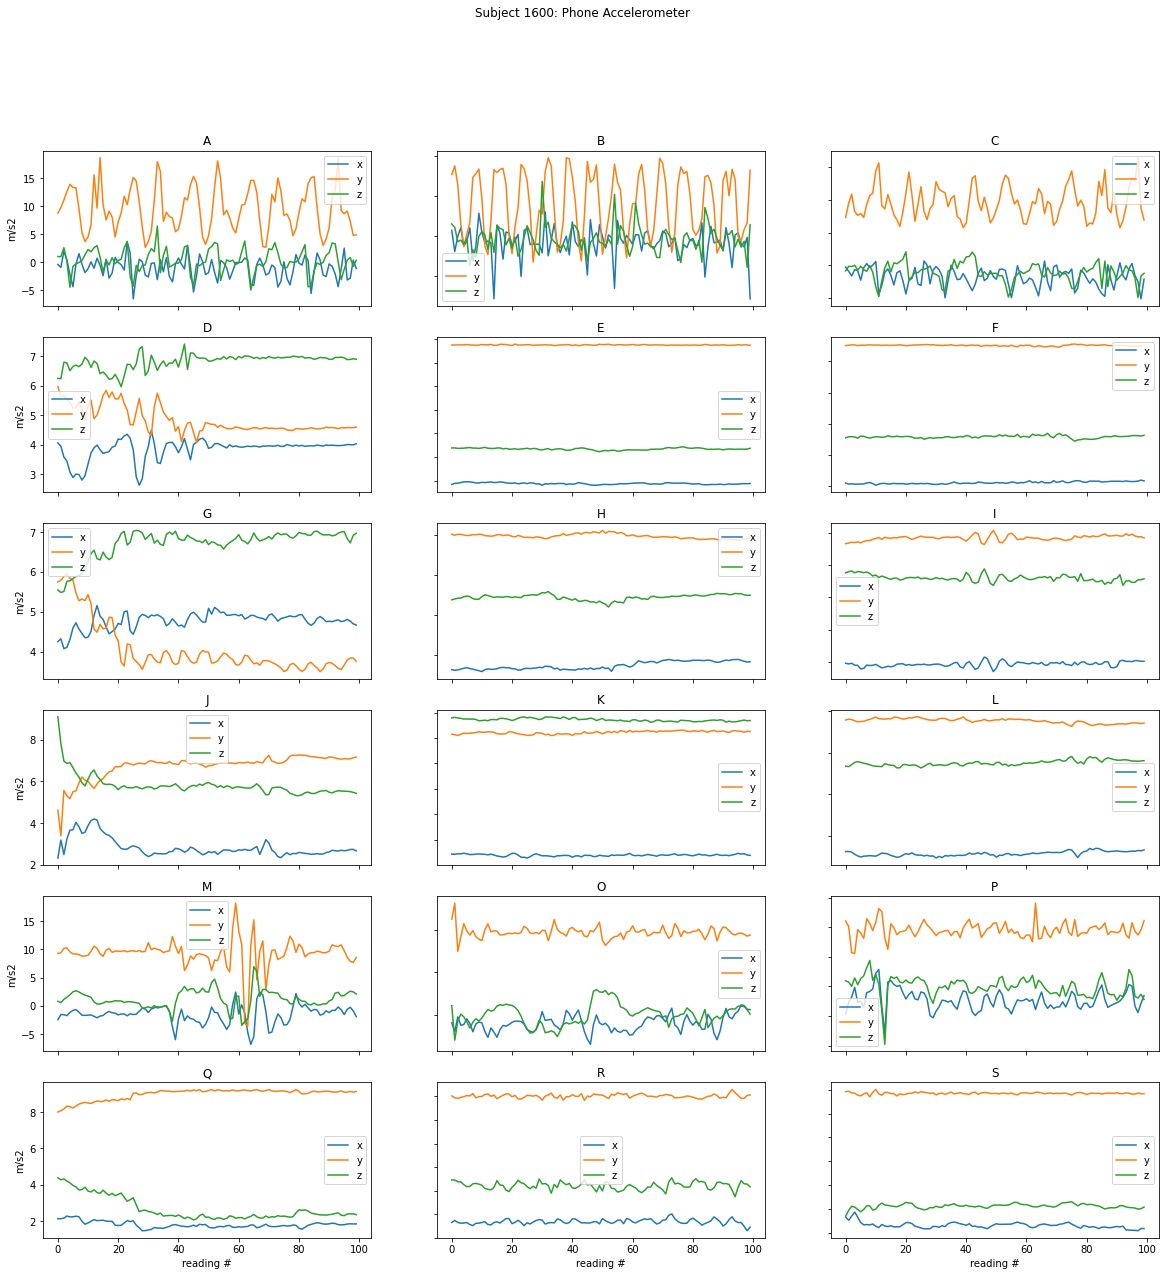

In [17]:
activities = phone_accel_df['activity_code'].unique().compute()
activity = pd.DataFrame()
for act in activities:
    temp_act = phone_accel_df[(phone_accel_df['subject_id'] == 1600) & (phone_accel_df['activity_code'] == act)].compute()[0:100]
    activity = pd.concat([activity, temp_act])
plot_activity(activity, title='Subject 1600: Phone Accelerometer', x_label='reading #', y_label='m/s2')

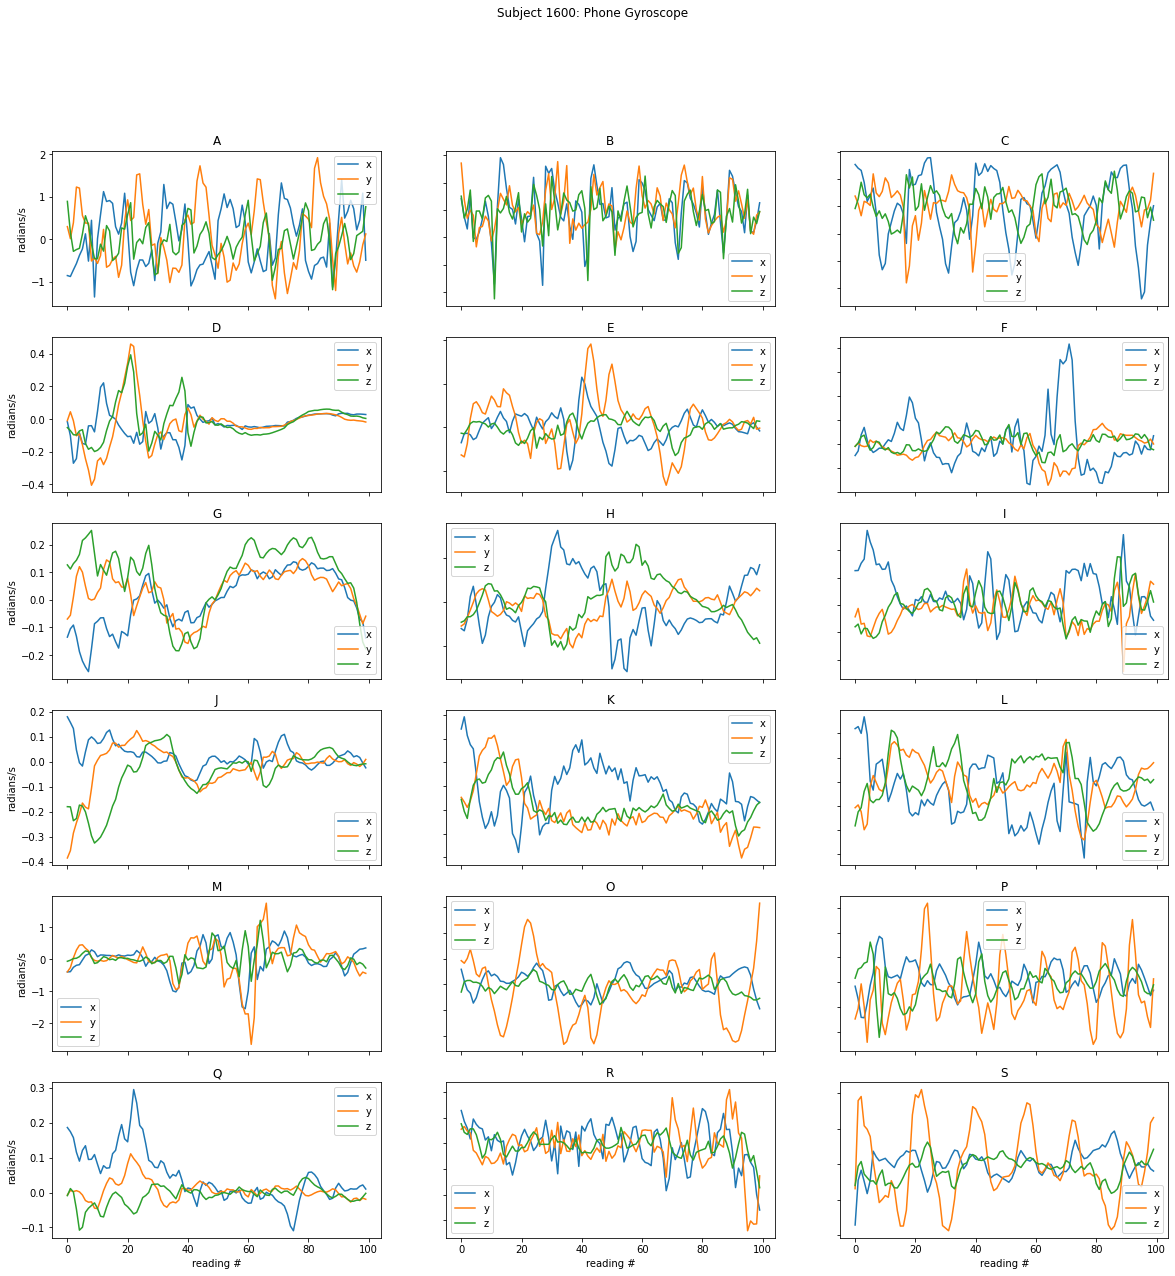

In [18]:
activities = phone_gyro_df['activity_code'].unique().compute()
activity = pd.DataFrame()
for act in activities:
    temp_act = phone_gyro_df[(phone_gyro_df['subject_id'] == 1600) & (phone_gyro_df['activity_code'] == act)].compute()[0:100]
    activity = pd.concat([activity, temp_act])
plot_activity(activity, title='Subject 1600: Phone Gyroscope', x_label='reading #', y_label='radians/s')

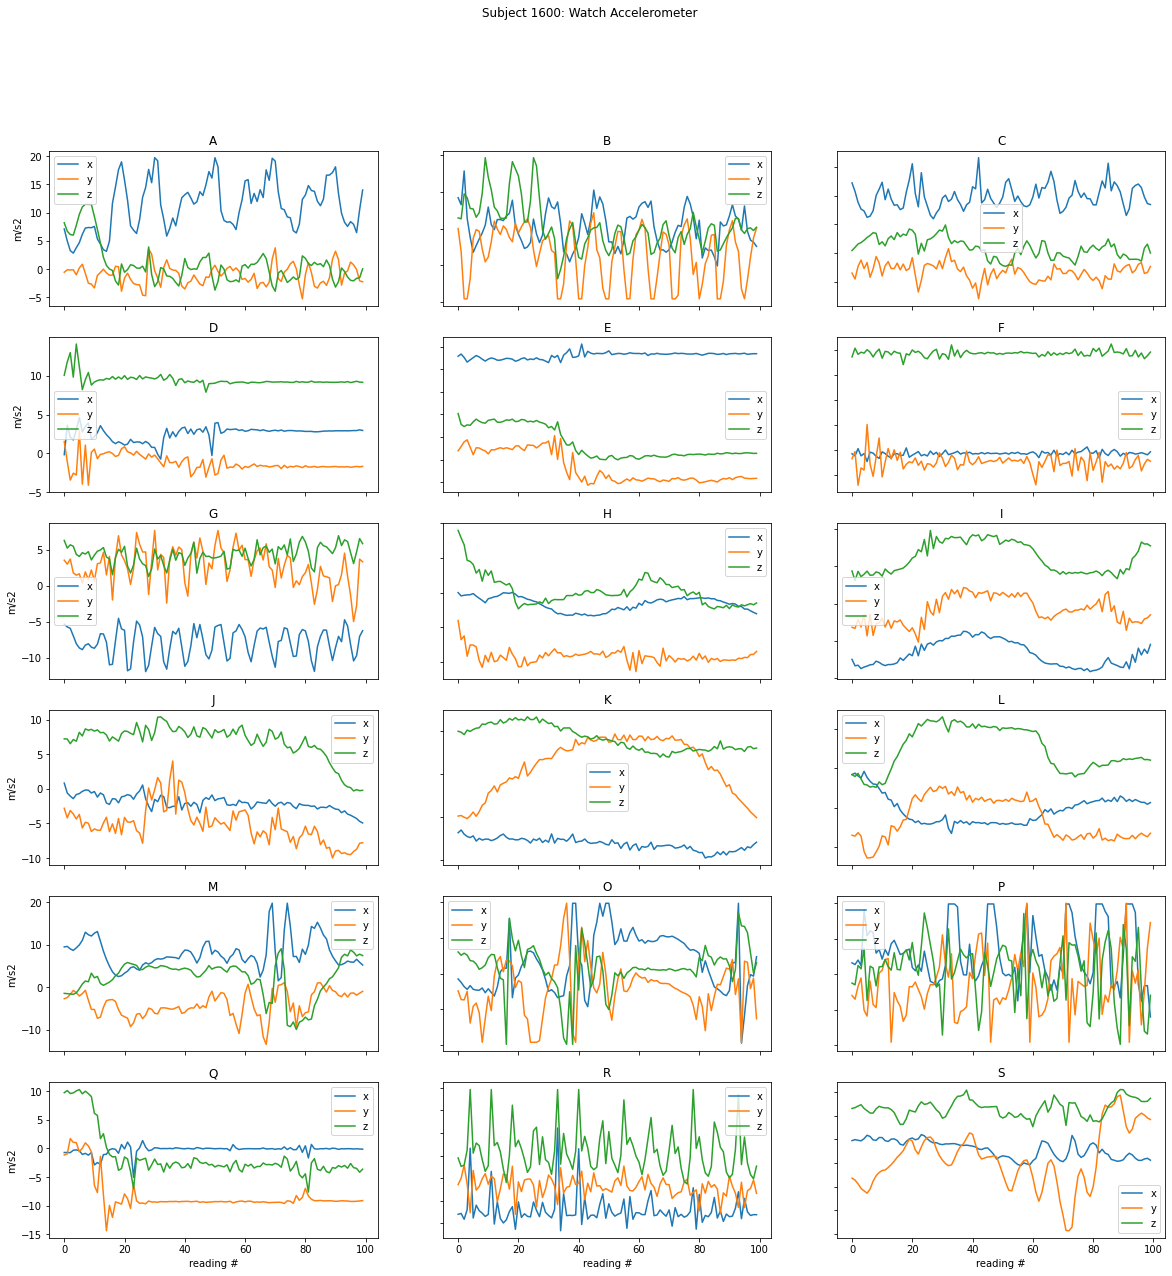

In [19]:
activities = watch_accel_df['activity_code'].unique().compute()
activity = pd.DataFrame()
for act in activities:
    temp_act = watch_accel_df[(watch_accel_df['subject_id'] == 1600) & (watch_accel_df['activity_code'] == act)].compute()[0:100]
    activity = pd.concat([activity, temp_act])
plot_activity(activity, title='Subject 1600: Watch Accelerometer', x_label='reading #', y_label='m/s2')

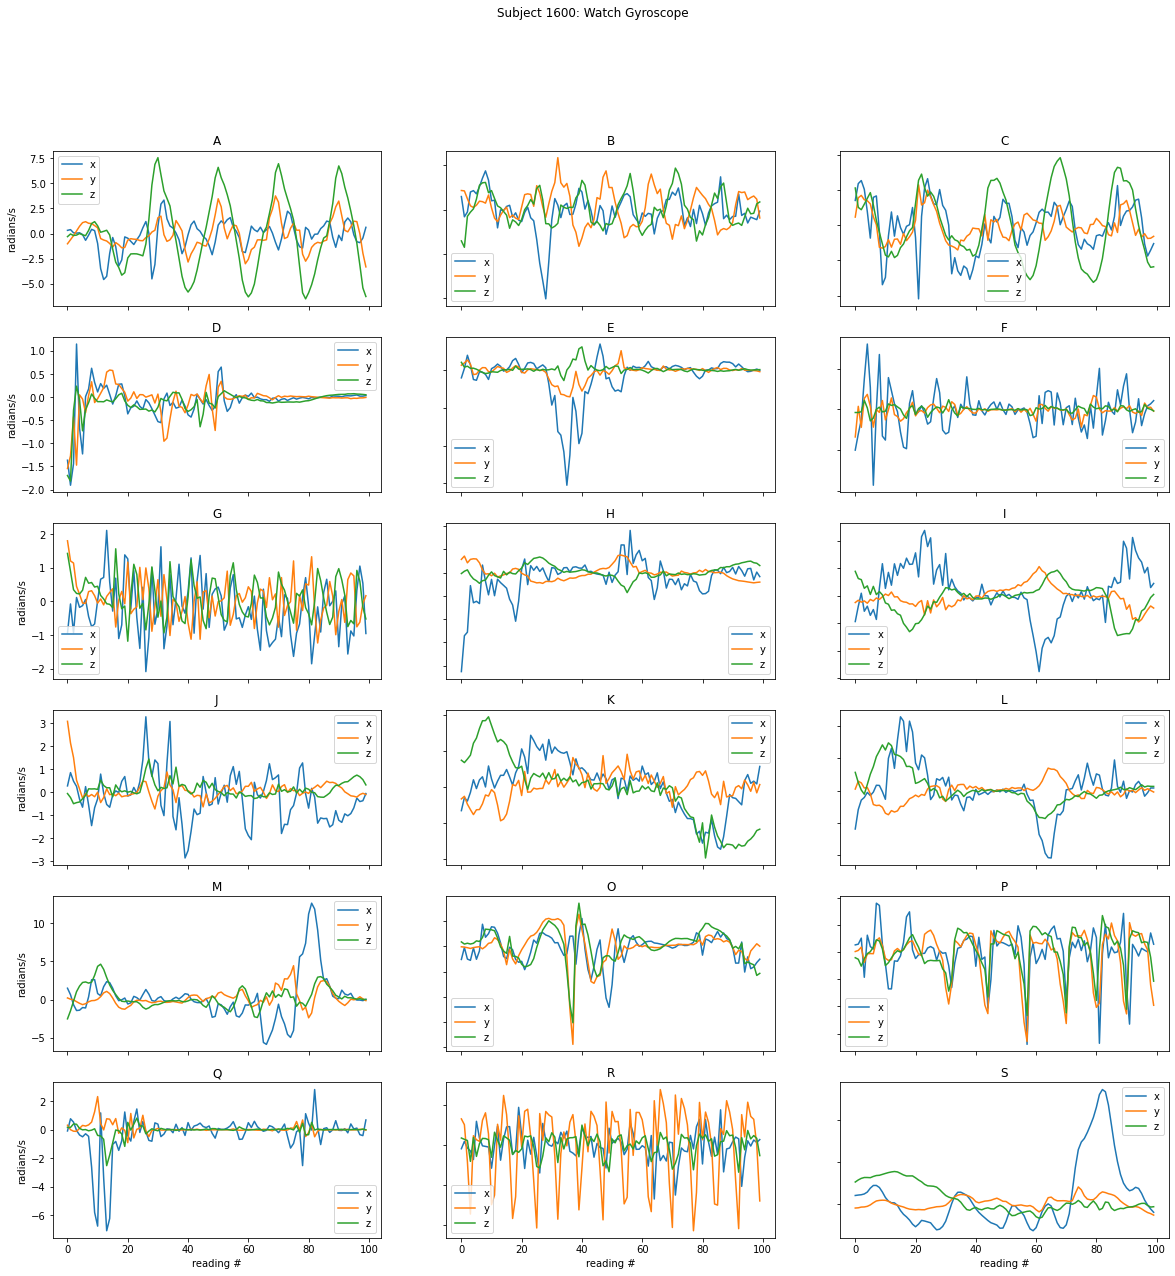

In [20]:
activities = watch_gyro_df['activity_code'].unique().compute()
activity = pd.DataFrame()
for act in activities:
    temp_act = watch_gyro_df[(watch_gyro_df['subject_id'] == 1600) & (watch_gyro_df['activity_code'] == act)].compute()[0:100]
    activity = pd.concat([activity, temp_act])
plot_activity(activity, title='Subject 1600: Watch Gyroscope', x_label='reading #', y_label='radians/s')

Summary of takeaways from EDA:
- Not all subjects performed all activities
- Some subjects may have performed certain activites with limited sensors recording
- Sensors potentially have different frequencies
- Timestamps/clocks between smartphone and smartwatch are not synced

### D. Data Preparation

*After noticing the timestamps/clocks being out of sync, but also reading that the device data was successfully joined in the original publication, contact was made, for clarifcation, to one of the professors involved/one of the co-authors, Gary Weiss, Professor within the Department of Computer and Information Science at Fordham University. It was clarified that the data was originally aligned on the assumption that each activity had the same start time and that there would not be much drift. For the rest of the analysis in this notebook, it will continue to be done under this same assumption.*

The data preparation step will be broken into the following tasks:
1. Group the sensor data into x second non-overlapping intervals, for each subject activity.
    - x = 3
    - aggregate/engineer desired features for each window in this step
2. Join the data by timestamp and/or interval index.

The following sensor combinations will be evaluated:

- **Phone** = phone_accel + phone_gyro
- **Watch** = watch_accel + watch_gyro
- **Both** = phone_accel + phone_gyro + watch_accel + watch_gyro

When training a model based on both, only activity data available with all 4 sensors will be considered.

In [66]:
# Create directories to persist data if they don't already exist
outdir = './data_persist'
if not os.path.exists(outdir):
    os.makedirs(f'{outdir}/phone/accel')
    os.makedirs(f'{outdir}/phone/gyro')
    os.makedirs(f'{outdir}/watch/accel')
    os.makedirs(f'{outdir}/watch/gyro')

In [70]:
def write_files(outputdirectory, filename_suffix, df):
    subjects = df['subject_id'].unique().compute()
    activities = df['activity_code'].unique().compute()
    
    # persist original df for performance gains
    # create copy for usage below
    df = df.persist()
    df_shift = df.copy()
    
    min_times = df_shift.groupby(['subject_id', 'activity_code']).min().reset_index().compute()
    df_shift['timestamp_shift_dt'] = ''
    
    count = 0
    for sub in subjects:
        subject_df = df_shift[(df_shift['subject_id'] == sub)].persist()
        for act in activities:
            min_ts = min_times[(min_times['subject_id'] == sub) & (min_times['activity_code'] == act)]['timestamp_dt']
            if len(min_ts == 1):
                min_ts = min_ts.item()
                floor_ts = min_ts.floor('min')
                offset_ts = min_ts-floor_ts
                subject_df['timestamp_shift_dt'] = subject_df['timestamp_shift_dt'].mask(((subject_df['activity_code'] == act)), (subject_df['timestamp_dt'] - offset_ts))
        subject_df['timestamp_shift_dt'] = dd.to_datetime(subject_df['timestamp_shift_dt'], origin='unix')
        subject_df = subject_df.compute()
        subject_df.to_csv(f'{outputdirectory}{sub}_{filename_suffix}.csv', sep=',', index=False, header=True)

In [72]:
%%time
write_files('./data_persist/phone/accel/', 'phone_accel', phone_accel_df)

CPU times: user 55.7 s, sys: 6.2 s, total: 1min 1s
Wall time: 2min 9s


In [74]:
%%time
write_files('./data_persist/phone/gyro/', 'phone_gyro', phone_gyro_df)

CPU times: user 53.5 s, sys: 6.59 s, total: 1min
Wall time: 2min 1s


In [75]:
%%time
write_files('./data_persist/watch/accel/', 'watch_accel', watch_accel_df)

CPU times: user 56 s, sys: 7.13 s, total: 1min 3s
Wall time: 2min 9s


In [93]:
%%time
write_files('./data_persist/watch/gyro/', 'watch_gyro', watch_gyro_df)

CPU times: user 50.9 s, sys: 6.01 s, total: 56.9 s
Wall time: 1min 56s


In [95]:
# Read files back in
def read_file_new(filepath):
    df = dd.read_csv(filepath, sep = ',', header=0)
    df['timestamp_dt'] = dd.to_datetime(df['timestamp_dt'], origin='unix')
    df['timestamp_shift_dt'] = dd.to_datetime(df['timestamp_shift_dt'], origin='unix')
    return df

In [98]:
# Phone Data
phone_accel_shift_df = read_file_new('data_persist/phone/accel/*.csv')
phone_gyro_shift_df = read_file_new('data_persist/phone/gyro/*.csv')

# Watch Data
watch_accel_shift_df = read_file_new('data_persist/watch/accel/*.csv')
watch_gyro_shift_df = read_file_new('data_persist/watch/gyro/*.csv')

In [99]:
# Confrim lengths back to original files
print('--NEW--')
print(f'Phone Accel:\t{len(phone_accel_shift_df)}')
print(f'Phone Gyro:\t{len(phone_gyro_shift_df)}')
print(f'Watch Accel:\t{len(watch_accel_shift_df)}')
print(f'Watch Gyro:\t{len(watch_gyro_shift_df)}')
print('--ORIG--')
print(f'Phone Accel:\t{len(phone_accel_df)}')
print(f'Phone Gyro:\t{len(phone_gyro_df)}')
print(f'Watch Accel:\t{len(watch_accel_df)}')
print(f'Watch Gyro:\t{len(watch_gyro_df)}')

--NEW--
Phone Accel:	4804403
Phone Gyro:	3608635
Watch Accel:	3777046
Watch Gyro:	3440342
--ORIG--
Phone Accel:	4804403
Phone Gyro:	3608635
Watch Accel:	3777046
Watch Gyro:	3440342


In [21]:
#Run the group by strictly on the phone_gyro data
phone_gyro_grouped_df = phone_gyro_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [22]:
phone_gyro_grouped_mean_df = phone_gyro_grouped_df.agg(['mean', 'std']).fillna(0)
phone_gyro_grouped_mean_df.columns = phone_gyro_grouped_mean_df.columns.map('_'.join)
# phone_gyro_grouped_mean_df.head()

In [23]:
phone_accel_grouped_df = phone_accel_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [24]:
phone_accel_grouped_mean_df = phone_accel_grouped_df.agg(['mean', 'std']).fillna(0)
phone_accel_grouped_mean_df.columns = phone_accel_grouped_mean_df.columns.map('_'.join)
# phone_accel_grouped_mean_df.head()

In [25]:
phone_gyro_grouped_mean_df = phone_gyro_grouped_mean_df.reset_index()
phone_accel_grouped_mean_df = phone_accel_grouped_mean_df.reset_index()

In [26]:
# phone_gyro_grouped_mean_df.head()

In [27]:
# phone_accel_grouped_mean_df.head()

In [28]:
phone_grouped_means_df = phone_accel_grouped_mean_df.merge(phone_gyro_grouped_mean_df, on=["subject_id", "activity_code", "timestamp_dt"], how="inner", suffixes=['_accel', '_gyro'])
# phone_grouped_means_df = phone_grouped_means_df.drop(['timestamp_gyro'], axis=1)
# phone_grouped_means_df = phone_grouped_means_df.rename(columns={'timestamp_accel': 'timestamp'})
# phone_grouped_means_df.head()

In [29]:
# len(phone_grouped_means_df)

In [30]:
watch_gyro_grouped_df = watch_gyro_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [31]:
watch_gyro_grouped_mean_df = watch_gyro_grouped_df.agg(['mean', 'std']).fillna(0)
watch_gyro_grouped_mean_df.columns = watch_gyro_grouped_mean_df.columns.map('_'.join)
# watch_gyro_grouped_mean_df.head()

In [32]:
#Run the group by strictly on the watch_accel data
watch_accel_grouped_df = watch_accel_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [33]:
watch_accel_grouped_mean_df = watch_accel_grouped_df.agg(['mean', 'std']).fillna(0)
watch_accel_grouped_mean_df.columns = watch_accel_grouped_mean_df.columns.map('_'.join)
# watch_accel_grouped_mean_df.head()

In [34]:
watch_gyro_grouped_mean_df = watch_gyro_grouped_mean_df.reset_index()
watch_accel_grouped_mean_df = watch_accel_grouped_mean_df.reset_index()

In [35]:
# watch_gyro_grouped_mean_df.head()

In [36]:
# watch_accel_grouped_mean_df.head()

In [37]:
watch_grouped_means_df = watch_accel_grouped_mean_df.merge(watch_gyro_grouped_mean_df, on=["subject_id", "activity_code", "timestamp_dt"], how="inner", suffixes=['_accel', '_gyro'])
# watch_grouped_means_df = watch_grouped_means_df.drop(['timestamp_gyro'], axis=1)
# watch_grouped_means_df = watch_grouped_means_df.rename(columns={'timestamp_accel': 'timestamp'})
# watch_grouped_means_df.head()

In [38]:
# len(watch_grouped_means_df)

In [39]:
phone_grouped_clean_df = phone_grouped_means_df
watch_grouped_clean_df = watch_grouped_means_df

<h1>NO RUN ZONE</h1>

In [40]:
# Phone
# phone_combined_df = phone_accel_df.merge(phone_gyro_df, on=['subject_id', 'activity_code', 'timestamp_dt'], how='inner', suffixes=['_accel', '_gyro'])
# phone_combined_df = phone_combined_df.drop(['timestamp_gyro'], axis=1)
# phone_combined_df = phone_combined_df.rename(columns={'timestamp_accel': 'timestamp'})
# phone_combined_df.head()

In [41]:
# Watch
# watch_combined_df = watch_accel_df.merge(watch_gyro_df, on=['subject_id', 'activity_code', 'timestamp_dt'], how='inner', suffixes=['_accel', '_gyro'])
# watch_combined_df = watch_combined_df.drop(['timestamp_gyro'], axis=1)
# watch_combined_df = watch_combined_df.rename(columns={'timestamp_accel': 'timestamp'})
# watch_combined_df.head()

In [42]:
# Phone & Watch
# phone_watch_combined_df = phone_combined_df.merge(watch_combined_df, on=['subject_id', 'activity_code', 'timestamp_dt'], how='inner', suffixes=['_phone', '_watch'])
# phone_watch_combined_df.head()
# phone and watch data do not have times synced -- currently unable to use together

In [43]:
# print(f'Phone: {len(phone_combined_df)}')
# print(f'Watch: {len(watch_combined_df)}')

In [44]:
# corr_matrix_phone = phone_combined_df.corr()
# corr_matrix_phone.compute().style.background_gradient(cmap='coolwarm')

In [45]:
# corr_matrix_watch = watch_combined_df.corr()
# corr_matrix_watch.compute().style.background_gradient(cmap='coolwarm')

In [46]:
# phone_grouped_df = phone_combined_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])
# watch_grouped_df = watch_combined_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [47]:
# Timestamp grouping/interval count check
# size = phone_grouped_df.size().rename('count').to_frame()
# size.compute().value_counts().head(50)

In [48]:
# pd.Grouper check (to understand if it keeps the first or last of the interval)
# https://stackoverflow.com/questions/35898667/group-by-time-and-other-column-in-pandas
# sample_df = phone_accel_df.head(60)
# sample_group_df = sample_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

# print(sample_df.head())
# sample_group_df.agg(['mean', 'count'])

# Findings:
# groups by looking at whole second intervals
# shows timestamp for first time in interval

In [49]:
# phone_grouped_means_df = phone_grouped_df.mean().reset_index()
# phone_grouped_counts_df = phone_grouped_df.size().rename('count').reset_index()
# phone_grouped_means_df = phone_grouped_means_df.merge(phone_grouped_counts_df, on=['subject_id', 'activity_code', 'timestamp_dt'])
# print(f'Phone full: {len(phone_grouped_means_df)}')

# phone_grouped_clean_df = phone_grouped_means_df[phone_grouped_means_df['count'] > 20]
# print(f'Phone > 20: {len(phone_grouped_clean_df)}')

# watch_grouped_means_df = watch_grouped_df.mean().reset_index()
# watch_grouped_counts_df = watch_grouped_df.size().rename('count').reset_index()
# watch_grouped_means_df = watch_grouped_means_df.merge(watch_grouped_counts_df, on=['subject_id', 'activity_code', 'timestamp_dt'])
# print(f'Watch full: {len(watch_grouped_means_df)}')

# watch_grouped_clean_df = watch_grouped_means_df[watch_grouped_means_df['count'] > 20]
# print(f'Watch > 20: {len(watch_grouped_clean_df)}')

In [50]:
# phone = phone_grouped_clean_df['activity_code'].value_counts().rename('total').reset_index().compute().sort_values(by=['index'], ascending=True)
# watch = watch_grouped_clean_df['activity_code'].value_counts().rename('total').reset_index().compute().sort_values(by=['index'], ascending=True)

In [51]:
# total = phone['total'].sum()

# plt.figure(figsize=(10,5))

# plt.plot(phone['index'], (phone['total']/total*100), label='phone')
# plt.plot(watch['index'], (watch['total']/total*100), label='watch')

# plt.title('Data Distribution by Activity Code')
# plt.xlabel('Activity Code')
# plt.ylabel('% of Respective Dataset')
# plt.legend()
# plt.show()

<h1>END OF NO RUN ZONE</h1>

# 2. Model Selection & Training

In [52]:
# train test split with 80-20 split
import dask_ml.model_selection

data_columns = ['x_mean_accel', 'y_mean_accel', 'z_mean_accel', 'x_mean_gyro', 'y_mean_gyro', 'z_mean_gyro', 'x_std_accel', 'y_std_accel', 'z_std_accel', 'x_std_gyro', 'y_std_gyro', 'z_std_gyro']
label_columns = ['activity_code']

# drop subject and timestamps from train data
phone_data_all = phone_grouped_clean_df[data_columns]
phone_labels_all = phone_grouped_clean_df[label_columns]

# drop subject and timestamps from train data
watch_data_all = watch_grouped_clean_df[data_columns]
watch_labels_all = watch_grouped_clean_df[label_columns]

X_train_phone, X_test_phone, y_train_phone, y_test_phone = dask_ml.model_selection.train_test_split(phone_data_all, phone_labels_all, shuffle = True, random_state=0, test_size = 0.2)
X_train_watch, X_test_watch, y_train_watch, y_test_watch = dask_ml.model_selection.train_test_split(watch_data_all, watch_labels_all, shuffle = True, random_state=0, test_size = 0.2)

In [53]:
print(f'X_train_phone: {len(X_train_phone)}')
print(f'X_test_phone: {len(X_test_phone)}')
print(f'y_train_phone: {len(y_train_phone)}')
print(f'y_test_phone: {len(y_test_phone)}')

X_train_phone: 44119
X_test_phone: 11130
y_train_phone: 44119
y_test_phone: 11130


In [54]:
print(f'X_train_watch: {len(X_train_watch)}')
print(f'X_test_watch: {len(X_test_watch)}')
print(f'y_train_watch: {len(y_train_watch)}')
print(f'y_test_watch: {len(y_test_watch)}')

X_train_watch: 44139
X_test_watch: 11134
y_train_watch: 44139
y_test_watch: 11134


In [55]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_phone = RandomForestClassifier(random_state=0)

with joblib.parallel_backend('dask'):
    clf_phone.fit(X_train_phone, y_train_phone)

<timed exec>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 6.84 s, sys: 1.19 s, total: 8.02 s
Wall time: 37.3 s


In [56]:
%%time

clf_watch = RandomForestClassifier(random_state=0)

with joblib.parallel_backend('dask'):
    clf_watch.fit(X_train_watch, y_train_watch)

<timed exec>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 7.18 s, sys: 1.07 s, total: 8.24 s
Wall time: 35.5 s


# 3. Model Test

In [57]:
# test /validate and provide final accurracy
# with joblib.parallel_backend('dask'):
#     score = randomForestClassifier.score(X_test_reset, X_test_labels)
# score

In [58]:
# from sklearn.metrics import confusion_matrix
# with joblib.parallel_backend('dask'):
#     confusion_matrix(X_test_labels, randomForestClassifier.predict(X_test_reset) )

In [59]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

with joblib.parallel_backend('dask'):
    predicted_labels_phone = clf_phone.predict(X_test_phone)

CPU times: user 3.55 s, sys: 418 ms, total: 3.96 s
Wall time: 15.1 s


In [60]:
%%time

with joblib.parallel_backend('dask'):
    predicted_labels_watch = clf_watch.predict(X_test_watch)

CPU times: user 3.18 s, sys: 421 ms, total: 3.6 s
Wall time: 14.2 s


In [61]:
%%time

with joblib.parallel_backend('dask'):
    print(accuracy_score(y_test_phone, predicted_labels_phone))

0.8375561545372866
CPU times: user 11.8 s, sys: 1.6 s, total: 13.4 s
Wall time: 1min


In [62]:
%%time

with joblib.parallel_backend('dask'):
    print(accuracy_score(y_test_watch, predicted_labels_watch))

0.7886653493802767
CPU times: user 10.9 s, sys: 1.22 s, total: 12.2 s
Wall time: 53.9 s


In [63]:
unique_phone_labels = np.unique(y_test_phone)
# unique_phone_labels

In [64]:
unique_watch_labels = np.unique(y_test_watch)
# unique_watch_labels

In [65]:
%%time
cm_phone = confusion_matrix(y_test_phone, predicted_labels_phone, labels = unique_phone_labels)
# cm_phone

CPU times: user 10.8 s, sys: 1.41 s, total: 12.2 s
Wall time: 56.4 s


<AxesSubplot:>

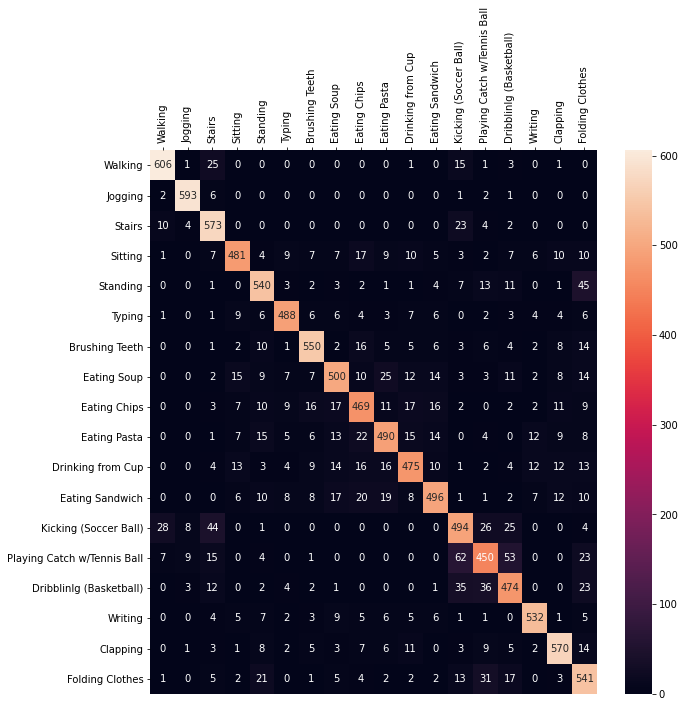

In [66]:
import matplotlib.pyplot as plt
display_labels = ["Walking", "Jogging", "Stairs", "Sitting", "Standing", "Typing", "Brushing Teeth", "Eating Soup", "Eating Chips", "Eating Pasta", "Drinking from Cup", "Eating Sandwich", "Kicking (Soccer Ball)", "Playing Catch w/Tennis Ball", "Dribblinlg (Basketball)", "Writing", "Clapping", "Folding Clothes"]

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sns.heatmap(cm_phone, annot=True, fmt='g', xticklabels = display_labels, yticklabels = display_labels)

In [67]:
%%time
cm_watch = confusion_matrix(y_test_watch, predicted_labels_watch, labels = unique_watch_labels)
# cm_watch

CPU times: user 11.3 s, sys: 1.33 s, total: 12.6 s
Wall time: 56.9 s


<AxesSubplot:>

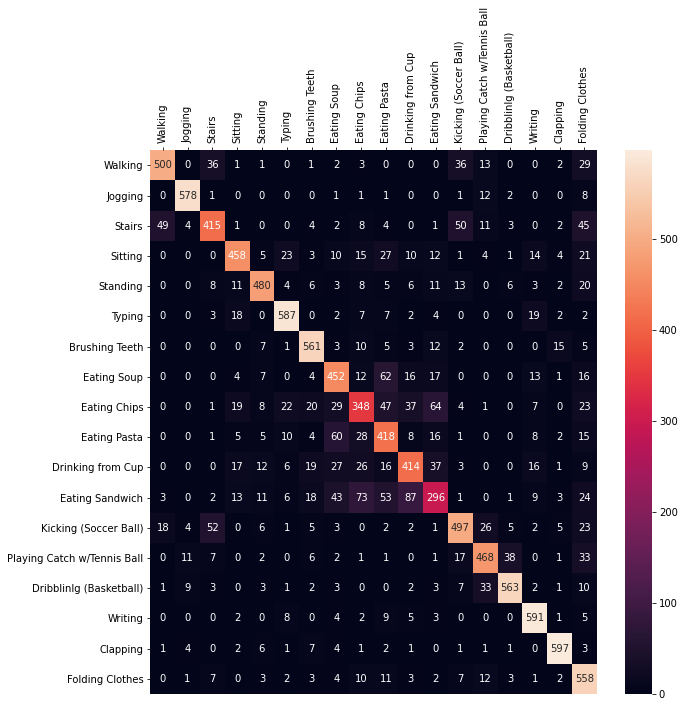

In [68]:
import matplotlib.pyplot as plt
display_labels = ["Walking", "Jogging", "Stairs", "Sitting", "Standing", "Typing", "Brushing Teeth", "Eating Soup", "Eating Chips", "Eating Pasta", "Drinking from Cup", "Eating Sandwich", "Kicking (Soccer Ball)", "Playing Catch w/Tennis Ball", "Dribblinlg (Basketball)", "Writing", "Clapping", "Folding Clothes"]

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
sns.heatmap(cm_watch, annot=True, fmt='g', xticklabels = display_labels, yticklabels = display_labels)

In [69]:
# %%time
# confusion_matrix(y_test_phone, predicted_labels_phone)

In [70]:
# %%time
# confusion_matrix(y_test_watch, predicted_labels_watch)

# 4. Results & Conclusion

In [71]:
client.shutdown()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
